In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import ring_dataset, randomized_ring_dataset, energy_randomized_ring_dataset, pattern_randomized_ring_dataset
from models import DGBaNR, big_DGBaNR

/home/J000000000007/envs/DGBaN/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load dataset:

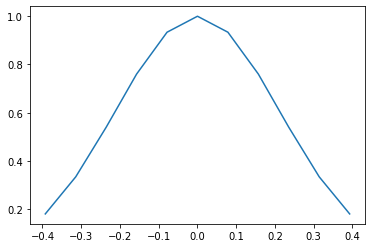

In [79]:
low, high, sig = -np.pi / 8, np.pi / 8, 0.3
noise_distr = np.arange(low, high + 1e-6, (high - low) / 10)
prob_distr = np.exp(-(noise_distr)**2 / sig**2)
plt.plot(noise_distr, prob_distr)
plt.show()

In [56]:
data_gen = pattern_randomized_ring_dataset(N=32)
features, imgs = data_gen.generate_dataset(data_size=100, seed=42, device='cpu', test_return=True)

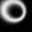

In [72]:
Image.fromarray((imgs[np.random.choice(100)] * 255).astype(np.uint8))

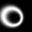

In [54]:
Image.fromarray((noise[5] * 255).astype(np.uint8))

In [6]:
img = data_gen.gaussian_ring(100)[0][np.random.choice(100)]
print(img.min(), img.max())
Image.fromarray(((img - img.min()) * 255 / (img.max() - img.min())).astype(np.uint8))

TypeError: gaussian_ring() missing 5 required positional arguments: 'center', 'mean', 'sig', 'theta', and 'phi'

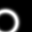

In [6]:
gaussian_ring, center, mean, sig = data_gen.gaussian_ring(1)
gaussian_ring, center, mean, sig = gaussian_ring[0], center[0], mean[0], sig[0]

features = torch.Tensor([[center[0], center[1], mean, sig, gaussian_ring.mean() * 32 * 32]])

Image.fromarray((gaussian_ring.reshape((32, 32)) * 255).astype(np.uint8))

Test generator:

In [4]:
# load generator
generator = big_DGBaNR(data_gen.n_features, 32, 'sigmoid')
generator.load_state_dict(torch.load('../save_model/big_DGBaNR_sigmoid_energy_random_1280000_32_Adam_mse_loss_5.pt', map_location=torch.device('cpu')))
print(generator.eval())
print('Number of parameters:', sum(p.numel() for p in generator.parameters()))

big_DGBaNR(
  (linear1): LinearReparameterization()
  (linear2): LinearReparameterization()
  (conv1): ConvTranspose2dReparameterization()
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2dReparameterization()
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2dReparameterization()
)
Number of parameters: 9461762


In [5]:
# setting the base feature
n_samples = 1000
feature = data_gen.scaler.transform(np.array([[15, 15, 9.4, 3.6]]))
features = [torch.Tensor(feature) for i in range(n_samples)]

# getting the predictions for this feature
pred_rings = np.zeros((n_samples, 32, 32))
with torch.no_grad():
    for i, tensor in enumerate(features):
        pred_rings[i] += generator(tensor)[0].numpy().squeeze()
pred_ring = pred_rings.sum(axis=0)

# summing the predictions
pred_prob = pred_ring * 255 / pred_ring.max()
true_prob = data_gen.gaussian_from_features(15, 15, 9.4, 3.6) * 255

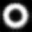

In [6]:
# predicted gaussian ring
Image.fromarray(pred_prob.astype(np.uint8))

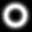

In [7]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

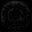

In [8]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [9]:
# MSE error
((pred_prob / pred_prob.max() - true_prob / true_prob.max())**2).mean()

0.0016992841367840816

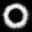

In [19]:
output = generator(features[0])[0].detach().numpy().squeeze()
Image.fromarray((output * 255 / output.max()).astype(np.uint8()))

In [114]:
np.arange(0, 1.01, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [125]:
pred

0      0.605736
1      0.581421
2      0.703866
3      0.295628
4      0.686699
         ...   
995    0.806955
996    0.534343
997    0.554463
998    0.657776
999    0.622060
Length: 1000, dtype: float64

In [159]:
pred_noise

(0.0, 0.05]    0.000000
(0.05, 0.1]    0.038835
(0.1, 0.15]    0.038835
(0.15, 0.2]    0.038835
(0.2, 0.25]    0.087379
(0.25, 0.3]    0.242718
(0.3, 0.35]    0.330097
(0.35, 0.4]    0.446602
(0.4, 0.45]    0.563107
(0.45, 0.5]    0.563107
(0.5, 0.55]    0.786408
(0.55, 0.6]    0.912621
(0.6, 0.65]    1.000000
(0.65, 0.7]    0.961165
(0.7, 0.75]    0.951456
(0.75, 0.8]    0.932039
(0.8, 0.85]    0.980583
(0.85, 0.9]    0.553398
(0.9, 0.95]    0.252427
(0.95, 1.0]    0.029126
dtype: float64

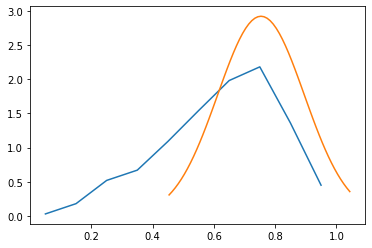

In [21]:
# getting the distribution for one pmt
pmt = (7, 7)
pred = pd.Series(pred_rings[:, 7, 7])
hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.01, 0.1))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * 0.1)

plt.plot(np.arange(0.05, 0.96, 0.1), pred_noise)

val = np.arange(-0.3, 0.3, 0.01) + true_prob[pmt] / 255
true_pmt_distr = np.exp(-(val - true_prob[pmt] / 255)**2 / 0.2**2)
true_pmt_distr /= true_pmt_distr.sum() * 0.01
plt.plot(val, true_pmt_distr)
plt.show()